# Model checking

In the last part you have been introduced to LTL formulas and you have seen that we can easily check whether a formula/automaton is equivalent to another.

But how does this work?
In order to check if two automata A1 and A2 accept the same language, we have to check if $L(A1) = L(A2)$.
This is however not feasible, we therefore follow a different approach:
$L(A1) \cap \overline{L(A2)} = L(A1) \cap L(\overline{A2}) = L(A1 \times \overline{A2}) = \emptyset$?
and
$\overline{L(A1)} \cap L(A2) = L(\overline{A1}) \cap L(A2) = L(\overline{A1} \times A2) = \emptyset$?
That is we check whether the language of A1 intersects with the complement of the language of A2.

This is known as model checking, and a run in the product automaton $A1 \times \bar{A2}$ is a witness for bad behaviour.

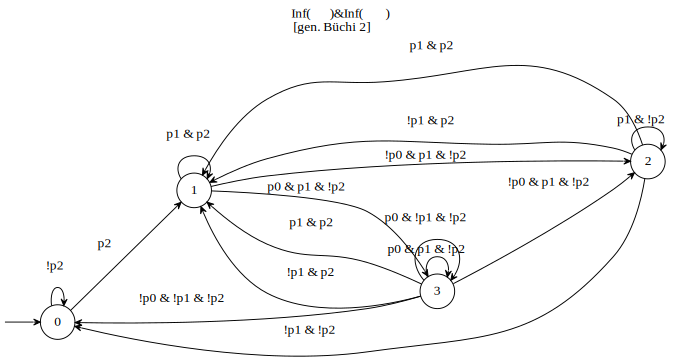

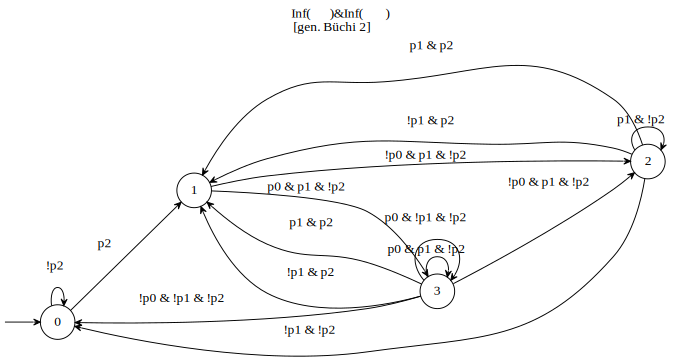

In [1]:
from AAA_utils import *
# How to compute and highlight a run
A1 = spot.translate("G(p2 -> X(p1 xor (p0 U Gp1))) & GFp2")
A2 = spot.translate("G(p2 -> X(p1 xor (p0 U Gp1))) & GFp2 & G(p2 -> X(~p2))", dict=A1.get_dict()) # Use the same propositions
display(A1.show("kbr"))
display(A2.show("kbr"))

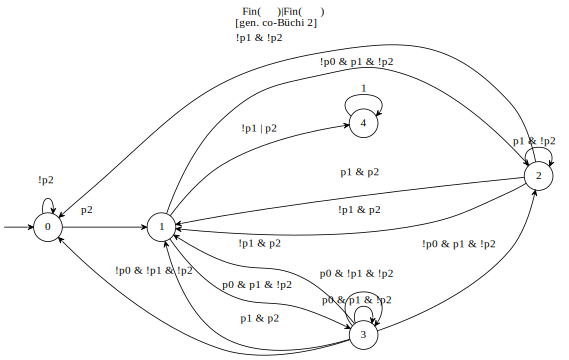

In [2]:
#First we need to completement A2
A2c = spot.complement(A2)
display(A2c.show("kbr"))

In [3]:
# Then we can check if there is a common run
r = A1.intersecting_run(A2c)
# r is not None, so it exists, and we have shown A1 != A2
r.highlight(1)
print(r)

Prefix:
  0
  |  p2	{0,1}
  1
  |  p1 & p2	{1}
Cycle:
  1
  |  !p0 & p1 & !p2
  2
  |  !p1 & !p2	{0}
  0
  |  p2	{0,1}



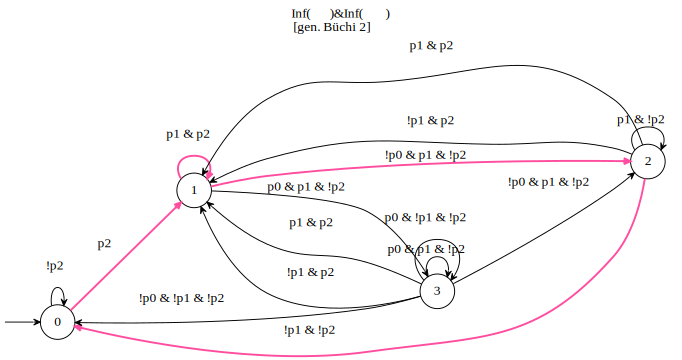

In [4]:
display(A1.show("kbr"))

# A practical example

In practice, you typically give your specifications as LTL but not your models.
In the course you have shortly discussed multiple file formats and programs to do this.

For the rest of this part we are concerned with an elevator model.

## Part 1

Below the elevator model as well as a naive controller is given.
In the first part, you need to write a specification (in LTL) that is
  1) Reasonable from an applicative view-point
  2) Violated by the behaviour of the elevator model controlled by the naive controller

In the following model, the global variable `req[i]` is `1` iff the elevator has been requested on floor `i`.
Variable `t` represents the *target* floor of the lift, and `p` its current *position*.
The `go` is a Boolean that the controller sets to instruct the cabin to move, and that the cabin reset upon reaching the target floor.

In [5]:
%%dve lift_model
byte req[4];
int t,p;
byte go;

process cabin
{
  state idle, mov, open;
  init idle;
  trans
    idle -> mov  {guard go>0;},
    mov -> open  {guard t==p;},
    mov -> mov   {guard t<p; effect p=p-1;},
    mov -> mov   {guard t>p; effect p=p+1;},
    open -> idle {effect req[p]=0,go=0;};
}

process environment
{
  state read;
  init read;
  trans
    read -> read {guard req[0]==0; effect req[0]=1;} ,
    read -> read {guard req[1]==0; effect req[1]=1;} ,
    read -> read {guard req[2]==0; effect req[2]=1;} ,
    read -> read {guard req[3]==0; effect req[3]=1;};
}

process controller
{
  state work;
  init work;
  trans
    work -> work {guard req[0]==1 && go==0; effect t=0, go=1;},
    work -> work {guard req[1]==1 && go==0; effect t=1, go=1;},
    work -> work {guard req[2]==1 && go==0; effect t=2, go=1;},
    work -> work {guard req[3]==1 && go==0; effect t=3, go=1;};
}

system async;

Evaluating the above cell has compiled and loaded the model.  The argument of `%%dve` is the name of a variable that serves as a handle to that model.  Printing this variable will list all global variables

In [6]:
lift_model

ltsmin model with the following variables:
  req[0]: byte
  req[1]: byte
  req[2]: byte
  req[3]: byte
  t: int
  p: int
  go: byte
  cabin: ['idle', 'mov', 'open']
  environment: ['read']
  controller: ['work']

To build a state space, we can use the `kripke()` method.  The argument is a list of atomic propositions (involving the model's variables) we want to use to label the Kripke structure.  If we just want to count the number of reachable states, we can just pass an empty list.

In [7]:
k = lift_model.kripke([])
print(f"Model has {spot.stats_reachable(k).states} states and {spot.stats_reachable(k).edges} transitions")

Model has 352 states and 976 transitions


Using the specialized `lift_display()`, we can explore the start of the state space.  Do not try to display too many states, because the graph layout (done by GraphViz) will be very time consuming.

In [8]:
@interact(n=IntSlider(1, 1, 150, 5))
def uncover_state_space(n):
    return lift_display(k, n)

interactive(children=(IntSlider(value=1, description='n', max=150, min=1, step=5), Output()), _dom_classes=('w…

# Model Checking the lift

Now after examining the model and the associated `naive` controller,
you might be aware of its flaws (If not look closer).

Write a LTL specification that makes reasonable assumptions about how lifts should work and which exposes the fact that the controller is not good enough.

To do so you need to:
  1) Write the LTL specification
  2) Translate its negation into an automaton
  3) Show that this automaton and the model intersect
  4) Analyse the trace (you can display a run using lift_display)

In [9]:
# LTL formula

In [10]:
# Translation

In [11]:
# Generate a new kripke structure that is aware of the atomic propositions
# spot.atomic_prop_collect allows you to get all propositions of a formula

In [12]:
# Intersect and highlight the run

# Controller synthesis

You have your model and your specification.
Are you able to conceive a controller respecting our own specification?

In [13]:
%%dve lift_model_2
byte req[4];
int t,p;
byte go;

process cabin
{
  state idle, mov, open;
  init idle;
  trans
    idle -> mov  {guard go>0;},
    mov -> open  {guard t==p;},
    mov -> mov   {guard t<p; effect p=p-1;},
    mov -> mov   {guard t>p; effect p=p+1;},
    open -> idle {effect req[p]=0,go=0;};
}

process environment
{
  state read;
  init read;
  trans
    read -> read {guard req[0]==0; effect req[0]=1;} ,
    read -> read {guard req[1]==0; effect req[1]=1;} ,
    read -> read {guard req[2]==0; effect req[2]=1;} ,
    read -> read {guard req[3]==0; effect req[3]=1;};
}

process controller
{
  Your controller here
}

system async;

30:3-30:7  syntax error
Parsing interrupted.
Error in a syntax of DVE source



CalledProcessError: Command '['divine', 'compile', '--ltsmin', '/media/philipp/cc069263-05da-48d7-bc4c-5fa691826046/git/TP_AAA/tmp4btlgk2u.dve']' died with <Signals.SIGSEGV: 11>.

Again by the means of model checking, make sure that is controller truly verifies the specification!

In [ ]:
# Model checking of lift_model_2 here